In [ ]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
from IPython.display import HTML
import matplotlib.animation as anim
import matplotlib;
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import hj_reachability as hj
import time
from functools import partial

import seaborn as sns
import pandas as pd


import jax.scipy as jsc
import functools
from jax.tree_util import register_pytree_node_class


jcm = jax.default_device(jax.devices()[2])
jcm.__enter__()

In [ ]:
#Boundary
def dirichlet(x, pad_width: int):
    return jnp.pad(x, ((pad_width, pad_width)), "constant", constant_values=3.0)

def termination_condn(x_target, r, x, t):
    return jnp.linalg.norm(x_target - x)<=r


def dg_x(params, arg):
    x, y, t = arg[0], arg[1], arg[2]
    return _dg_x(t,x,y,params)

def dg_y(params, arg):
    x, y, t = arg[0], arg[1], arg[2]
    return _dg_y(t,x,y,params)


def _dg_x(t,x,y,params):
    eps = params[0]
    A = params[1]
    omega = params[2]
    a = eps*jnp.sin(omega*t)
    b = 1-2*a
    f = a*(x**2) + b*x
    return -jnp.pi*A*jnp.sin(jnp.pi*f)*jnp.cos(jnp.pi*y)


def _dg_y(t,x,y,params):
    eps, A, omega = (*params,)
    a = eps*jnp.sin(omega*t)
    b = 1-2*a
    f = a*(x**2) + b*x
    df = 2*(a*x) + b
    return jnp.pi*A*jnp.cos(jnp.pi*f)*jnp.sin(jnp.pi*y)*df


v_dg_x = jax.vmap(_dg_x,(None,0,0,0),0)
v_dg_y = jax.vmap(_dg_y,(None,0,0,0),0)

In [ ]:
# #%% Run reachability on the current agumented problem
# # init settings
# target settings

grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo=np.array([0., 0.]),
                                                                        hi=np.array([2., 1.])), (101, 51),
                                                              boundary_conditions=(dirichlet, dirichlet))
times = np.linspace(0, -2.0, 101)
# params = [1.,1.,0.1]

def get_val_func(x_init,x_target, params, grid=grid, times=times):
    # general settings
    # for backwards reachability
    
    uMode = 'min'


#     grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo=np.array([-1., 0.]),
#                                                                         hi=np.array([1., 1.])), (101, 101))
    initial_values = hj.shapes.shape_sphere(grid=grid, center=x_target, radius = 0.02 )

    def multi_reach_step(mask, time, val):
        val = jnp.where(mask<0,-1,val)
        return val

    p_multi_reach_step = partial(multi_reach_step, initial_values)

    solver_settings = hj.SolverSettings.with_accuracy("high",
                                                      #x_init=x_init,
                                                      artificial_dissipation_scheme=
                                                          hj.artificial_dissipation.local_local_lax_friedrichs,
                                                        hamiltonian_postprocessor = p_multi_reach_step
                                                      )


    def y_cur(arg):
        return dg_x(params, arg)

    def x_cur(arg):
        return dg_y(params, arg)


    # run the solver
    Plat2D = hj.systems.Platform2Dcurrents(u_max=0.7, control_mode=uMode, x_current=x_cur, y_current=y_cur)

    # On CPU takes time: compile:219s    compute: 5s
    start = time.time()
    all_values = hj.solve(solver_settings, Plat2D, grid, times, initial_values, progress_bar=False)
    
    return all_values

#hj.viz.visSet2DAnimation(grid, all_values, times, type='html', x_init=x_init, colorbar=False

In [ ]:
from jax import jacfwd, jacrev, jit
_key = jax.random.PRNGKey(1)
key, _key = jax.random.split(_key)

In [ ]:
x_init = jnp.array([0.25, 0.5])
x_target = jnp.array([1.6, 0.5])

termination_condn = partial(termination_condn, x_target, r=1e-2)

get_val_func_params = lambda params: get_val_func(x_init, x_target, params)

v_val = jax.vmap(get_val_func_params,0,0)

In [7]:
n_mc = 150
eps = (jax.random.normal(key,shape=[n_mc,1])*0.1 + 0.1)
key, _key = jax.random.split(_key)
A = (jax.random.normal(key,shape=[n_mc,1])*0.05 + 0.5)
key, _key = jax.random.split(_key)
omega = (jax.random.normal(key,shape=[n_mc,1])*0.1 + 4.)

params = jnp.concatenate([eps,A,omega],axis=1)
true_params = jnp.array([0.15,0.525,3.95])

In [8]:
all_all_values = v_val(params)

mean_all_values = jnp.mean(all_all_values, 0)

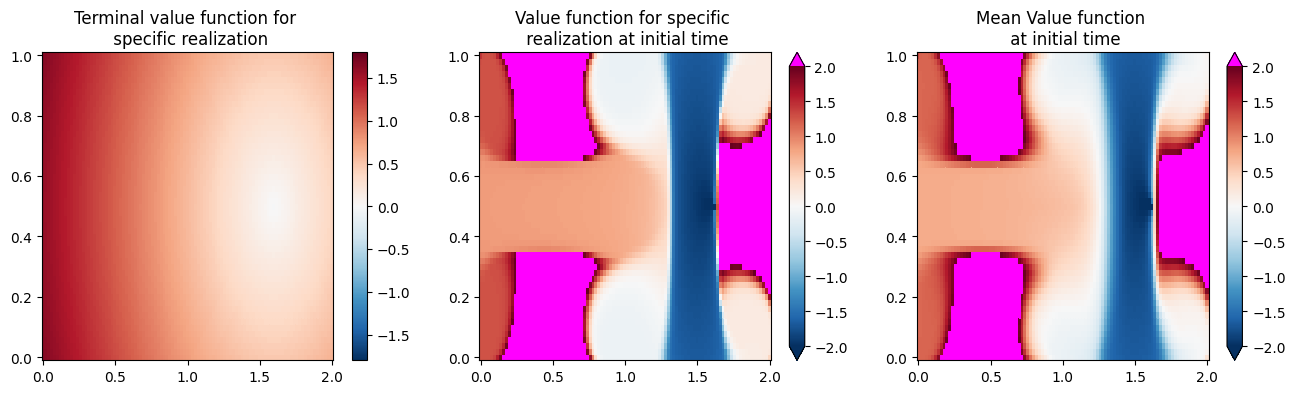

In [9]:
fig, axs = plt.subplots(1,3, figsize=(16,4))
cmp = matplotlib.colormaps['RdBu_r']
cmp.set_over('magenta')
ivf = axs[0].pcolor(grid.states[...,0], grid.states[...,1], all_all_values[2,0,:,:],cmap=cmp,
                   vmin=-1.8,vmax=1.8); plt.colorbar(ivf, ax=axs[0])
tvf = axs[1].pcolor(grid.states[...,0], grid.states[...,1], all_all_values[2,-1,:,:],cmap=cmp,
                    vmin=-2, vmax=2); plt.colorbar(tvf, ax=axs[1],extend='both')

tvfm = axs[2].pcolor(grid.states[...,0], grid.states[...,1], mean_all_values[-1,:,:],cmap=cmp,
                    vmin=-2, vmax=2); plt.colorbar(tvfm, ax=axs[2],extend='both')

axs[0].set_title("Terminal value function for \n specific realization")
axs[1].set_title("Value function for specific \n realization at initial time");
axs[2].set_title("Mean Value function \n at initial time");


In [10]:
n_mc, n_t, n_x, n_y = all_all_values.shape
dt = times[1] - times[0]

In [11]:
def traj_solve(params, times, val_func, x_init=x_init, grid=grid):
    def y_cur(arg):
        return dg_x(params, arg)

    def x_cur(arg):
        return dg_y(params, arg)
    
    Plat2D = hj.systems.Platform2Dcurrents(u_max=1.0, control_mode='min', x_current=x_cur, y_current=y_cur)
    
    x_traj = jnp.zeros((grid.ndim, len(times)-1))
    
    x_final = x_init
    x_traj = x_traj.at[:,0].set(x_final)
    for i,time in enumerate(times[:1:-1]):
        u_opt, d_opt = Plat2D.get_opt_ctrl_from_values(grid, x_final, time, times, val_func)
        dt = times[-i-1] - times[-i-2]
        x_final = x_final - dt*jnp.array(Plat2D(x_final,u_opt,d_opt,time))
        x_traj = x_traj.at[:,i+1].set(x_final)
    return x_traj

In [12]:
v_traj_solve = jax.vmap(traj_solve, (0,None,None),0)

In [13]:
params_wt = jnp.c_[params.T,true_params].T

In [14]:
all_traj = v_traj_solve(params_wt, times[-20:], mean_all_values[-20:,:,:])

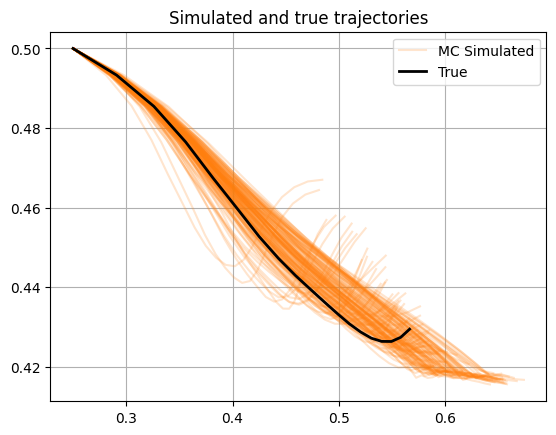

In [15]:
fig,ax = plt.subplots()

#for i in range(n_mc):
L = ax.plot(all_traj[:,0,:].T,all_traj[:,1,:].T,alpha=0.2,color='C1')
L[0].set_label("MC Simulated")

ax.plot(all_traj[-1,0,:],all_traj[-1,1,:],alpha=1,color='k', lw=2, label="True")

ax.set_title("Simulated and true trajectories")
ax.legend()
# ax.set_xlim([0,1])
# ax.set_ylim([0,1])
ax.grid()
    

In [16]:
all_traj_shape = all_traj.shape

In [17]:
reduced_all_traj = np.linalg.svd(all_traj.reshape(all_traj_shape[0],-1),full_matrices=False)

In [49]:
n_traj_modes = 6
traj_info = reduced_all_traj[0][:,:n_traj_modes]

traj_obs = traj_info[-1,:]
traj_info = traj_info[:-1,:]

In [50]:
all_info = np.concatenate([params,traj_info],1)

In [51]:
import pandas as pd

In [52]:
dataset = pd.DataFrame({'param 0': all_info[:, 0], 'param 1': all_info[:, 1], 'param 2': all_info[:, 2],
                        'traj 0': all_info[:, 3], 'traj 1': all_info[:, 4], 'traj 2': all_info[:, 5],
                       })

In [53]:
sns.pairplot(dataset)

In [54]:
from gmm_jax import GMM
key, _key = jax.random.split(_key)

In [86]:
prior_mean = jnp.mean(all_info,0)

In [90]:
prior_demean = all_info - prior_mean

In [93]:
num_gmm = 5
num_dim = all_info.shape[1]

unfit_gmm = GMM(Π=(jnp.ones(num_gmm))/(num_gmm),
                μ=jax.random.normal(key, shape=[num_gmm,num_dim]),
                Σ=jnp.array([jnp.eye(num_dim) for i in range(num_gmm)]))

In [94]:
fitted_gmm, num_iter = unfit_gmm.fit_gmm(prior_demean, thresh=1e-4)

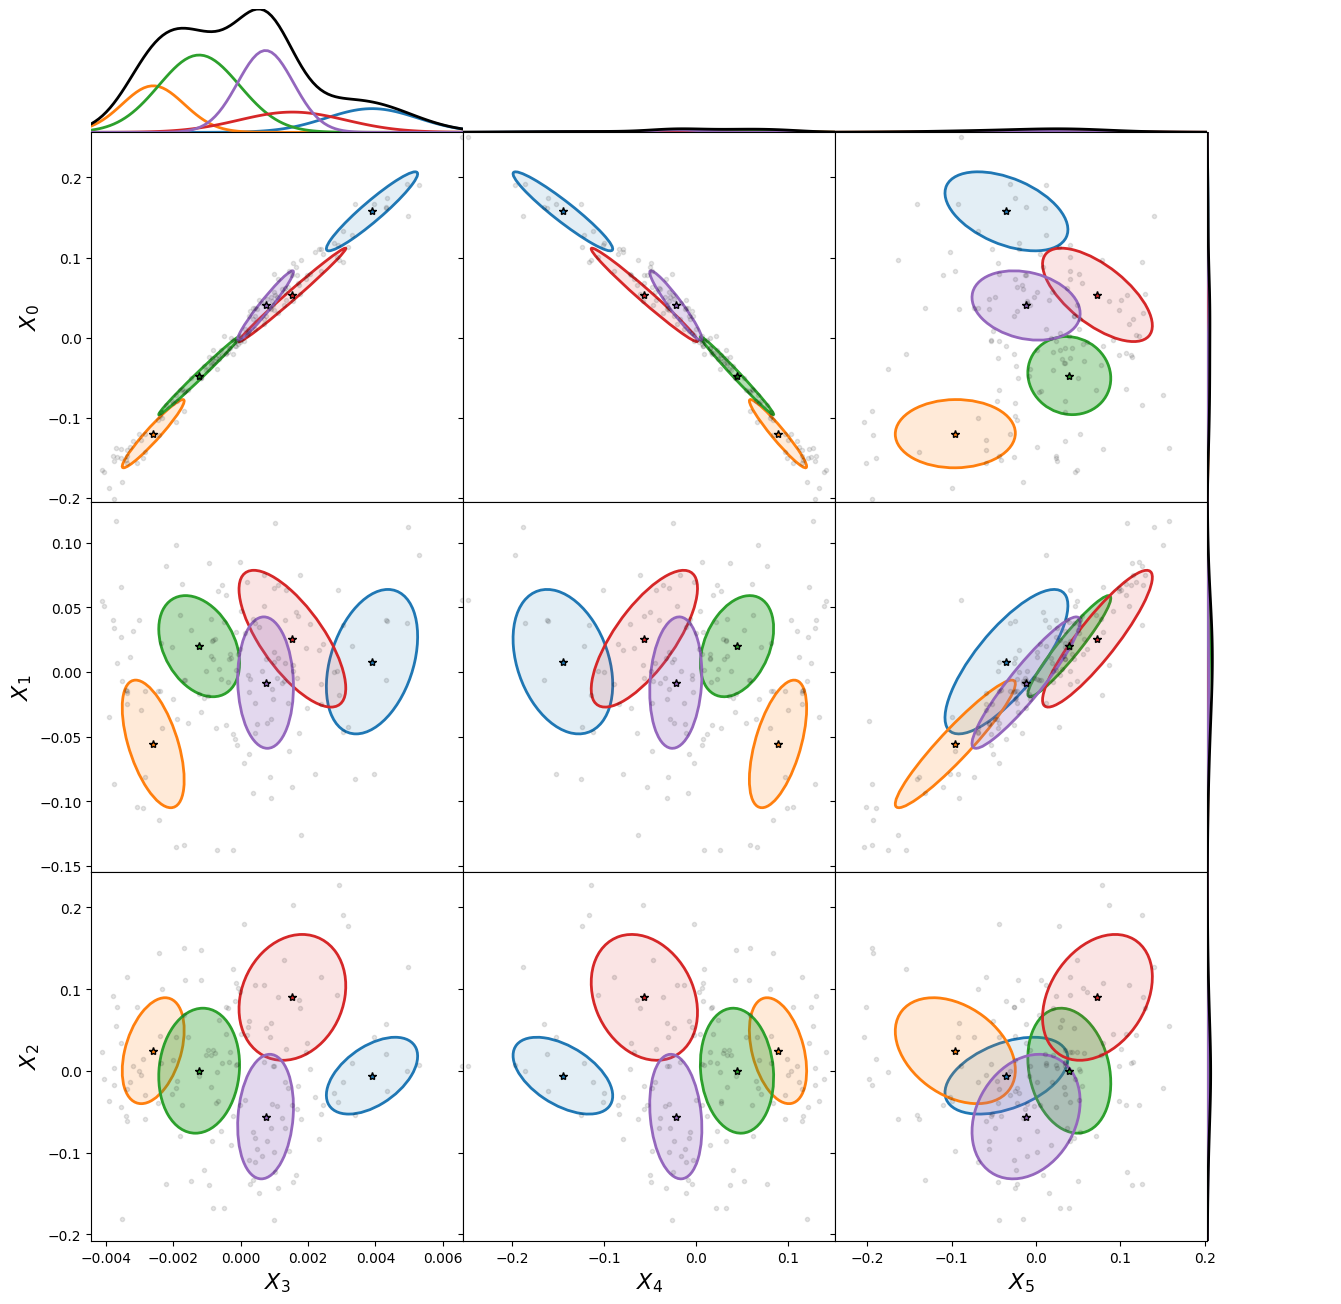

In [107]:
fitted_gmm.plot(left_vars=[0,1,2], top_vars=[3,4,5], samples=prior_demean);

In [108]:
H = jnp.zeros([traj_obs.size,num_dim])
H = H.at[:,-traj_obs.size:].set(jnp.eye(traj_obs.size))
R = 0.0005*jnp.eye(H.shape[0])

posterior = fitted_gmm.get_posterior(H, traj_obs, R)

In [109]:
posterior.plot(left_vars=[0,1,2], top_vars=[3,4,5], samples=prior_demean);

In [110]:
posterior, posterior_mean = posterior.demean()

In [112]:
param_posterior_estimate = (posterior_mean+prior_mean)[:3]

In [113]:
true_params

DeviceArray([0.15 , 0.525, 3.95 ], dtype=float32)

In [114]:
param_posterior_estimate

DeviceArray([0.14090364, 0.52083445, 3.9462936 ], dtype=float32)

In [117]:
prior_mean[:3]

DeviceArray([0.0832889 , 0.49674088, 3.9987216 ], dtype=float32)